In [1]:
import pandas as pd
import numpy as np
import os
import zipfile
import geopandas as gpd
from shapely.geometry import Point

In [14]:
years = range(2008, 2024)

# List to store DataFrames
dataframes = []

for year in years: 
    # Define the folder path containing the files
    folder_path = f'../data/raw/inmet/unzip/{year}'  # Replace with your folder path

    # Get a list of all CSV files in the folder
    file_list = [f for f in os.listdir(folder_path) if f.endswith('.CSV')]  # Adjust file extension if needed

    # Loop through each file in the list
    for file in file_list:
        file_path = os.path.join(folder_path, file)  # Get full file path
        
        try:
            # Read the first 7 rows (adjust this if more rows are needed)
            df0 = pd.read_csv(file_path, sep=';', encoding='ISO-8859-1', skiprows=0, decimal=',', nrows=7)

            # Create a new dictionary to store station info
            df_station = {}

            # Extract station information and handle errors if necessary
            df_station['REGIAO'] = df0.iloc[0, 1] if len(df0) > 1 else None
            df_station['ESTACAO'] = df0.iloc[1, 1] if len(df0) > 1 else None
            df_station['CODIGO(WMO)'] = df0.iloc[2, 1] if len(df0) > 2 else None
            df_station['LATITUDE'] = float(df0.iloc[3, 1].replace(',', '.')) if len(df0) > 3 and df0.iloc[3, 1] else None
            df_station['LONGITUDE'] = float(df0.iloc[4, 1].replace(',', '.')) if len(df0) > 4 and df0.iloc[4, 1] else None
            df_station['ALTITUDE'] = float(df0.iloc[5, 1].replace(',', '.')) if len(df0) > 5 and df0.iloc[5, 1] else None
            df_station['DATAFUNDACAO'] = df0.iloc[6, 1] if len(df0) > 6 else None
            df_station['ANO'] = year
            
            # Convert to DataFrame and append to the list
            df_stations = pd.DataFrame([df_station])
            dataframes.append(df_stations)

        except Exception as e:
            print(f"Error processing file {file}: {e}")

# Combine all DataFrames into a single DataFrame
df_stations_final = pd.concat(dataframes, ignore_index=True)

# Display the first few rows
df_stations_final.head()


,REGIAO,ESTACAO,CODIGO(WMO),LATITUDE,LONGITUDE,ALTITUDE,DATAFUNDACAO,ANO
0,DF,BRASILIA,A001,-15.789444,-47.925833,1159.54,2000-05-07,2008
1,DF,AGUAS EMENDADAS,A045,-15.596389,-47.625833,1200.00,2008-10-03,2008
2,GO,GOIANIA,A002,-16.642778,-49.220000,770.00,2001-05-29,2008
3,GO,MORRINHOS,A003,-17.716667,-49.100000,771.42,2001-05-25,2008
4,GO,SAO SIMAO,A011,-18.966667,-50.616667,488.51,2006-07-15,2008


### Definição de funções

In [16]:
# Função para calcular a distância usando a fórmula de Haversine em vetor
def haversine_vectorized(lat1, lon1, lat2, lon2):
    # Raio da Terra em quilômetros
    R = 6371.0
    
    # Converter as latitudes e longitudes de graus para radianos
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)
    
    # Diferença de latitudes e longitudes
    delta_lat = lat2_rad - lat1_rad
    delta_lon = lon2_rad - lon1_rad
    
    # Fórmula de Haversine em vetor
    a = np.sin(delta_lat / 2) ** 2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(delta_lon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    # Distância em quilômetros
    distance = R * c
    return distance

### Dados de entrada dos municípios

In [17]:
shape = gpd.read_file('../data/raw/shapefiles/SP.shp')

shapeM = gpd.read_file('../data/raw/shapefiles/SP_Municipios_2022.shp')
LON = shapeM['xcentroide'].values
LAT = shapeM['ycentroide'].values
points_centroids = list()
for j in range(len(LON)):
    point_centroids = Point(LON[j], LAT[j])
    points_centroids.append(point_centroids)
    gdf_centroids = gpd.GeoDataFrame(geometry=points_centroids).set_crs(shapeM.crs)

### Gera a matriz de distancia entre as estações

In [18]:
# Número de estacoes
n_stations = len(df_stations_final) 
n_municipios = len(LAT)

# Extrair latitudes e longitudes do DataFrame
latitudes  = df_stations_final['LATITUDE'].values
longitudes = df_stations_final['LONGITUDE'].values

# Criar uma matriz de distâncias x5 usando broadcasting
distances = np.zeros((n_municipios, n_stations))


# Usando broadcasting para calcular todas as distâncias
for i in range( n_municipios ):
    distances[i] = haversine_vectorized(LAT[i], LON[i], latitudes, longitudes)

# Precomputando 1/distances
inv_distances = 1 / distances

# np.fill_diagonal(inv_distances, 0.0)

# Exibir a matriz de distâncias
distance_df = pd.DataFrame(distances, columns=df_stations_final['CODIGO(WMO)'], index=shapeM['CD_MUN'])

distance_df.head(2)

CODIGO(WMO),A001,A045,A002,A003,A011,A012,A013,A014,A015,A016,...,A849,A850,A855,A869,A871,A872,A873,A874,A875,A876
CD_MUN,,,,,,,,,,,,,,,,,,,,,
3500105,723.494429,757.314468,582.010360,476.075140,294.244884,673.877955,643.122670,634.637167,751.186342,412.325184,...,222.323760,163.176912,535.749169,275.919120,260.040517,312.609105,493.452445,478.395168,536.633939,553.559093
3500204,638.045281,668.098253,518.720697,401.494889,277.352856,585.403230,658.092619,597.232356,701.706227,432.423796,...,366.277984,297.953816,646.009426,408.504562,281.458128,337.426644,476.906744,510.721717,593.861320,632.671680


In [19]:
distance_df_filtered = distance_df.loc[:, distance_df.min() <= 280]
distance_df_filtered.head()

CODIGO(WMO),A003,A011,A016,A025,A034,A035,A704,A709,A710,A721,...,A825,A835,A842,A849,A850,A869,A871,A872,A873,A874
CD_MUN,,,,,,,,,,,,,,,,,,,,,
3500105,476.075140,294.244884,412.325184,421.972317,502.141044,402.936324,110.856945,296.620219,209.951834,403.193973,...,354.028181,221.883608,209.999773,222.323760,163.176912,275.919120,260.040517,312.609105,493.452445,478.395168
3500204,401.494889,277.352856,432.423796,413.860919,392.225790,323.834471,221.121814,445.823089,238.503744,552.603522,...,474.343534,332.308310,254.851202,366.277984,297.953816,408.504562,281.458128,337.426644,476.906744,510.721717
3500303,527.771624,506.212146,670.285153,628.081881,442.576461,462.854036,503.496648,699.390030,503.637359,810.892862,...,658.635285,523.908768,393.284274,605.193552,528.226362,621.610735,374.395089,408.063627,424.613874,539.966675
3500402,530.034450,523.879175,687.431861,641.577960,436.753343,468.678953,534.790435,736.523172,527.782310,847.783051,...,697.933487,563.036992,432.587973,643.075870,566.290980,660.498759,413.342014,446.181004,454.578863,574.779905
3500501,589.458709,571.121271,735.216074,693.080629,499.034770,526.048137,560.424052,743.205686,566.613283,855.310186,...,685.404234,555.866803,420.644627,646.175423,568.646143,655.952613,393.775558,419.862253,405.593108,534.975704


In [20]:

# Ensure that 'CODIGO(WMO)' exists as a column in df_stations_final
filtered_df_stations = df_stations_final[df_stations_final['CODIGO(WMO)'].isin(distance_df_filtered.columns)]
filtered_df_stations


,REGIAO,ESTACAO,CODIGO(WMO),LATITUDE,LONGITUDE,ALTITUDE,DATAFUNDACAO,ANO
3,GO,MORRINHOS,A003,-17.716667,-49.100000,771.42,2001-05-25,2008
4,GO,SAO SIMAO,A011,-18.966667,-50.616667,488.51,2006-07-15,2008
9,GO,JATAI,A016,-17.923889,-51.717778,582.00,2007-05-23,2008
13,GO,RIO VERDE,A025,-17.785833,-50.981389,782.00,2007-05-17,2008
18,GO,CATALAO,A034,-18.157778,-47.926389,890.00,2008-01-31,2008
...,...,...,...,...,...,...,...,...
3624,PR,CIDADE GAUCHA,A869,-23.359167,-52.931944,365.79,11/03/08,2023
3625,PR,JAPIRA,A871,-23.773333,-50.180556,692.88,29/02/08,2023
3626,PR,VENTANIA,A872,-24.280278,-50.210278,1093.41,15/04/11,2023
3627,PR,MORRETES,A873,-25.508889,-48.808611,50.31,13/03/08,2023


In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import seaborn as sns

shape = gpd.read_file('../data/raw/shapefiles/SP.shp')

shapeM = gpd.read_file('../data/raw/shapefiles/SP_Municipios_2022.shp')
LON = shapeM['xcentroide'].values
LAT = shapeM['ycentroide'].values
points_centroids = list()
for j in range(len(LON)):
    point_centroids = Point(LON[j], LAT[j])
    points_centroids.append(point_centroids)
    gdf_centroids = gpd.GeoDataFrame(geometry=points_centroids).set_crs(shapeM.crs)

In [86]:
import geopandas as gpd
import geobr
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs

def plot_station_locations(filtered_df_stations, years):
    """
    Plots station locations for given years and saves the plots as PDF files.

    Parameters:
    filtered_df_stations (pd.DataFrame): DataFrame containing the stations data.
    years (list or range): List or range of years to plot.

    Returns:
    None
    """
    # Calculate global min/max for LATITUDE and LONGITUDE for consistent axis limits
    nx = 0.02
    min_lon = filtered_df_stations['LONGITUDE'].min()*(1 + nx)
    max_lon = filtered_df_stations['LONGITUDE'].max()*(1 - nx)
    min_lat = filtered_df_stations['LATITUDE'].min()*(1 + nx)
    max_lat = filtered_df_stations['LATITUDE'].max()*(1 - nx)

    # Load the state shape for São Paulo
    gdf = geobr.read_state()
    gdf_sp = gdf # [gdf.abbrev_state == 'SP']

    for year in years:
        # Filter the dataframe for the current year
        stations_for_year = filtered_df_stations[filtered_df_stations['ANO'] == year]
        
        # Number of stations in the current year
        n_stat = len(stations_for_year)
        
        # Create the plot with Cartopy projection
        fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': ccrs.PlateCarree()})
        
        # Set title
        ax.set_title(f'{year} - # {n_stat} stations')
        
        # Plot the São Paulo state boundary
        gdf_sp.plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)
        
        # Plot the station locations as a scatter plot
        ax.scatter(
            stations_for_year['LONGITUDE'], 
            stations_for_year['LATITUDE'], 
            color='red', 
            s=20, 
            label='Stations'
        )
        
        # Set axis limits based on the global min/max
        ax.set_xlim(min_lon, max_lon)
        ax.set_ylim(min_lat, max_lat)
        
        # Add gridlines
        ax.gridlines(draw_labels=False, linewidth=0.5, color='black', alpha=0.3, linestyle='--')
        
        # Add a box around the plot
        plt.box(True)
        
        # Save the plot as a PDF file
        plt.savefig(f'Estacoes_{year}.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)
        plt.close()  # Close the plot to avoid memory issues if generating multiple plots


# Example of how to call the function
years = range(2008, 2024)
plot_station_locations(filtered_df_stations, years)

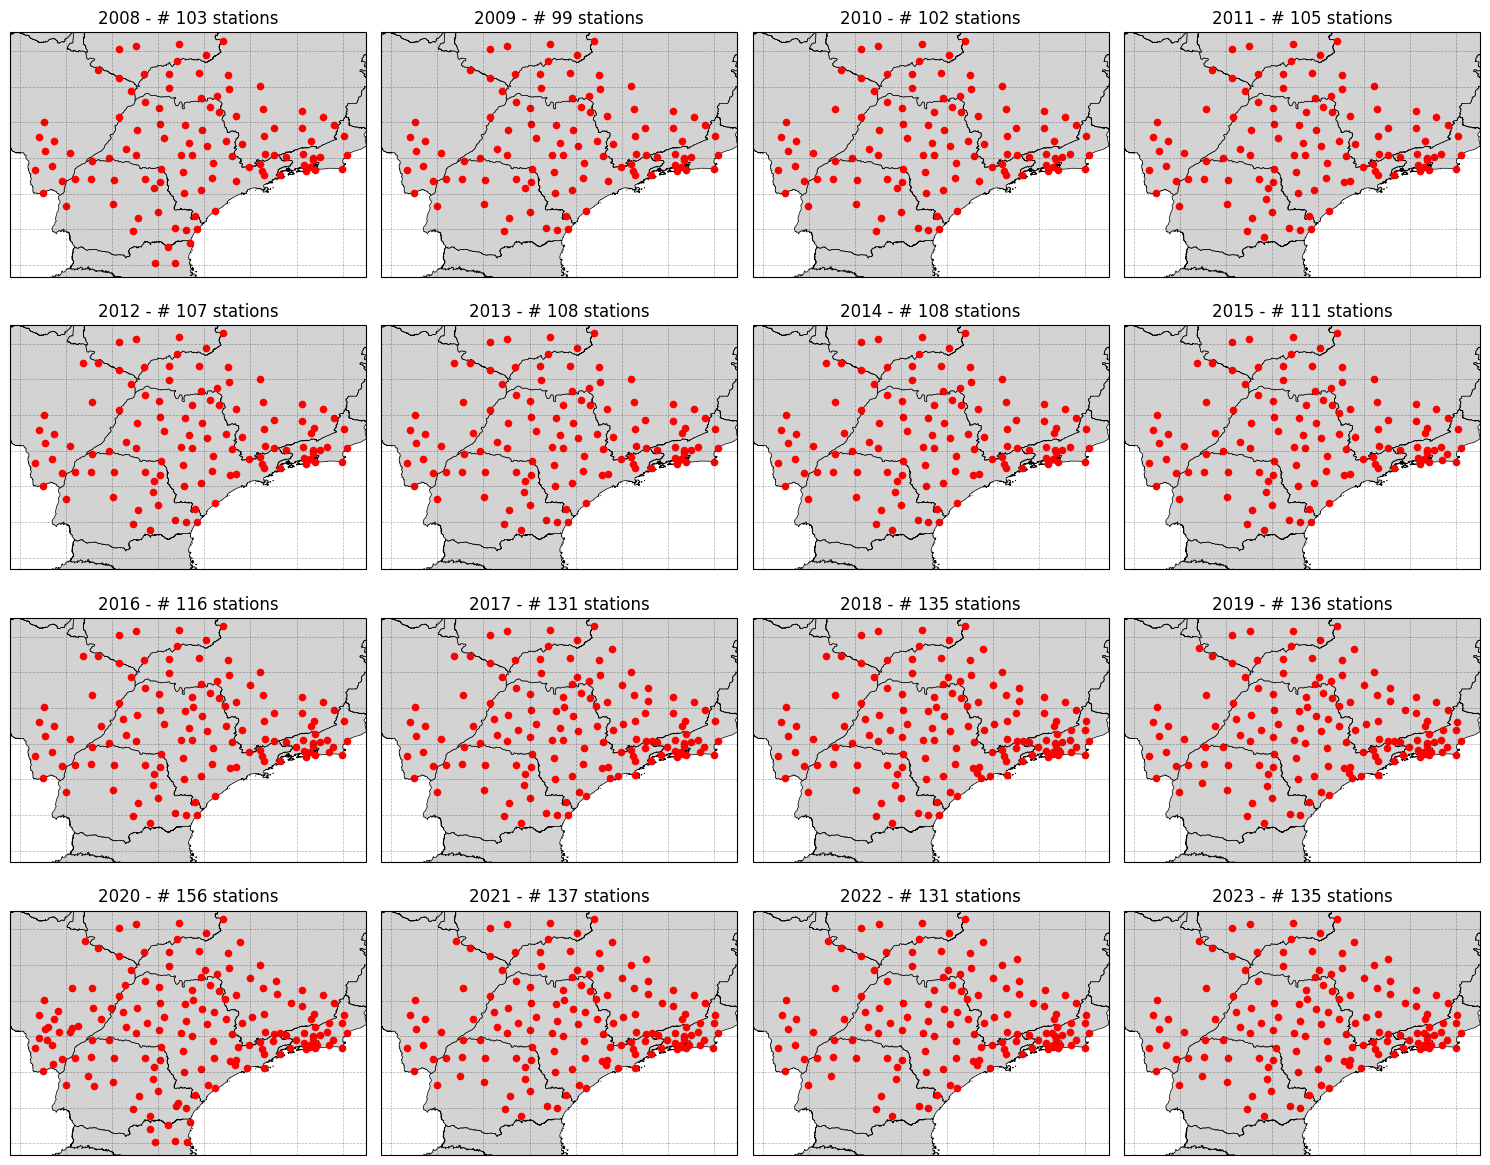

In [87]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

def plot_station_locations_all(filtered_df_stations, years, ncols=4):
    """
    Plots station locations for given years in a grid of subplots and saves the entire figure as a PDF file.

    Parameters:
    filtered_df_stations (pd.DataFrame): DataFrame containing the stations data.
    years (list or range): List or range of years to plot.
    ncols (int): Number of columns in the subplot grid (default is 3).

    Returns:
    None
    """
    # Calculate global min/max for LATITUDE and LONGITUDE for consistent axis limits
    nx = 0.02
    min_lon = filtered_df_stations['LONGITUDE'].min()*(1 + nx)
    max_lon = filtered_df_stations['LONGITUDE'].max()*(1 - nx)
    min_lat = filtered_df_stations['LATITUDE'].min()*(1 + nx)
    max_lat = filtered_df_stations['LATITUDE'].max()*(1 - nx)

    # Load the state shape for São Paulo
    gdf = geobr.read_state()
    gdf_sp = gdf #[gdf.abbrev_state == 'SP']

    # Calculate the number of rows for the subplot grid
    nrows = (len(years) // ncols) + (1 if len(years) % ncols != 0 else 0)

    # Create the main figure for all subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows * 3), subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Flatten the axes array for easier iteration
    axes = axes.flatten()

    for idx, year in enumerate(years):
        ax = axes[idx]
        
        # Filter the dataframe for the current year
        stations_for_year = filtered_df_stations[filtered_df_stations['ANO'] == year]
        
        # Number of stations in the current year
        n_stat = len(stations_for_year)
        
        # Set title
        ax.set_title(f'{year} - # {n_stat} stations')
        
        # Plot the São Paulo state boundary
        gdf_sp.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=0.5)
        
        # Plot the station locations as a scatter plot
        ax.scatter(
            stations_for_year['LONGITUDE'], 
            stations_for_year['LATITUDE'], 
            color='red', 
            s=20, 
            label='Stations'
        )
        
        # Set axis limits based on the global min/max
        ax.set_xlim(min_lon, max_lon)
        ax.set_ylim(min_lat, max_lat)
        
        # Add gridlines
        ax.gridlines(draw_labels=False, linewidth=0.5, color='black', alpha=0.3, linestyle='--')
        
    # Turn off any unused axes
    for i in range(len(years), len(axes)):
        fig.delaxes(axes[i])

    # Adjust layout
    plt.tight_layout()

    # Save the entire subplot as a PDF file
    plt.savefig('Estacoes_all_years.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)
    # plt.close()  # Close the plot to avoid memory issues if generating multiple plots
    
# Example of how to call the function
years = range(2008, 2024)
plot_station_locations_all(filtered_df_stations, years)